<a href="https://colab.research.google.com/github/dylpicklesTU26/dylanmurray/blob/main/FINAL_SUBMISSION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Dylan Murray and Maya Patri

Exploring Lyme Disease Trends  
[View this project on GitHub.io](https://github.com/dylpicklesTU26/dylanmurray)

# **Why this matters?**

Lyme disease is the most common vector-borne illness in the United States, with tens of thousands of cases reported annually–and likely many more undiagnosed. As climate patterns shift and tick populations expand into new geographic areas, understanding the relationship between environmental factors like temperature and Lyme disease incidence has become increasingly important for both public health officials and local communities.

Our goal is to use data science methods to explore whether temperature can help predict the presence or intensity of Lyme disease across U.S. counties. By combining CDC case data with historical climate records, we aim to uncover patterns that could inform early detection, targeted prevention efforts, and public awareness campaigns. This project not only addresses a relevant and growing public health concern, but also demonstrates how open data and statistical modeling can contribute to real-world decision-making.

# **Project Overview – Exploring Lyme Disease Trends in the U.S.**

This project analyzes historical Lyme disease incidence across U.S. counties using publicly available CDC datasets, focusing on trends within the past 23 years (2001 to 2023). Lyme disease, a bacterial infection transmitted by ticks, is among the most prevalent vector-borne illnesses in North America. Its symptoms can range from mild fatigue and fever to severe long-term complications, making early detection and prevention critical.

In **Milestone 1**, we visualized trends in disease incidence by state and year range to identify high-risk regions and time periods with notable increases in reported cases.

In **Milestone 2**, we expanded our analysis by integrating county-level climate data. Specifically, we examined whether temperature patterns—particularly average annual temperatures—correlate with Lyme disease incidence. After merging the datasets by State, County, and YearRange, we used exploratory visualizations and logistic regression to evaluate possible associations.

Our logistic regression analysis revealed a statistically significant but modest negative association between average temperature and the likelihood of a county exceeding 100 reported Lyme disease cases in a given year. This suggests that colder regions may be more likely to experience high Lyme activity, potentially due to environmental conditions that support tick habitats or influence human exposure patterns. While temperature alone is not a strong predictor, it may still play a role in broader models incorporating ecological and behavioral variables.


# **Research Questions:**

How has Lyme disease incidence changed across U.S. counties within the past 23 years?

Which states and regions show the highest incidence rates or the steepest increases?

Does average temperature correlate with Lyme disease cases at the county level?

# **Data Collection**

Lyme disease case data comes from the CDC – Lyme Disease Data and Surveillance (https://www.cdc.gov/lyme/data-research/facts-stats/index.html)

Temperature data comes from NOAA’s National Centers for Environmental Information (NCEI) (https://www.ncei.noaa.gov/access/monitoring/climate-at-a-glance/county/mapping/110/tavg/199603/60/value)

Our initial dataset for Lyme rates contained missing values (NaN) for Lyme incidence in some states, which required imputation before analysis and for temperature was aggregated and cleaned by year range for each county in the U.S.

#**Data Processing**

The first step was cleaning the data set, below is a step by step process of how we merged all of our diffrent csv files from the CDC and NOAA into one merged csv file.

In [ ]:
# IMPORT STANDARD LIBRARIES
from pathlib import Path
import pandas as pd
import re

# STEP 0  DEFINE THE ROOT DIRECTORY WHERE ALL CSV FILES LIVE
ROOT = Path("/content/drive/MyDrive/DataScienceProject")  # ADJUST IF NEEDED


In [ ]:
# STEP 1  FUNCTION THAT CONVERTS A CALENDAR YEAR TO THE FIVE YEAR ERA LABEL
# THE ERA LABELS MATCH THE TEMP FILE NAMES
def era(year: int) -> str:
    if   2000 <= year < 2005: return "2000-2005"
    elif 2005 <= year < 2010: return "2005-2010"
    elif 2010 <= year < 2015: return "2010-2015"
    elif 2015 <= year < 2020: return "2015-2020"
    else:                     return "2020-2025"   # CATCHES YEARS 2020 TO 2025

In [ ]:
# STEP 2  LOAD THE WIDE LYME CASE TABLE AND TURN IT INTO LONG FORMAT
# THEN TAG EACH ROW WITH THE PROPER ERA AND AGGREGATE CASES PER COUNTY ERA
lyme_path = ROOT / "Lyme.csv"               # FULL PATH TO LYME FILE
lyme_wide = pd.read_csv(lyme_path, encoding="latin1")

# PULL EVERY COLUMN THAT STARTS WITH CASES
case_cols = [c for c in lyme_wide.columns if c.lower().startswith("cases")]

# MELT MAKES ONE ROW PER YEAR INSTEAD OF ONE ROW WITH MANY YEAR COLUMNS
lyme_long = (
    lyme_wide
      .melt(id_vars=["Ctyname", "stname"], value_vars=case_cols,
            var_name="Year", value_name="Cases")
      .rename(columns={"Ctyname": "CountyName", "stname": "StateName"})
)

# EXTRACT THE FOUR DIGIT YEAR FROM THE COLUMN NAME AND CAST TO INTEGER
lyme_long["Year"] = lyme_long["Year"].str.extract(r"(\d{4})").astype(int)

# MAP THE YEAR TO ITS ERA LABEL
lyme_long["YearRange"] = lyme_long["Year"].apply(era)

# SUM ALL CASES FOR EACH COUNTY ERA COMBINATION
lyme_agg = (
    lyme_long
      .groupby(["StateName", "CountyName", "YearRange"], as_index=False)
      .agg(Cases=("Cases", "sum"))
)

In [ ]:
# STEP 3  LOAD EACH TEMPERATURE FILE, ADD THE ERA LABEL, AND CONCATENATE
# THE FILENAME ITSELF TELLS US THE START AND END OF THE ERA WINDOW
def read_temp(path: Path) -> pd.DataFrame:
    # EXTRACT NUMBERS AFTER TEMP_ USING REGEX LIKE TEMP_05-10
    match = re.search(r"Temp_(\d\d)-(\d\d)", path.stem)
    start = 2000 + int(match.group(1))              # CONVERT 05 TO 2005
    end   = 2000 + int(match.group(2))              # CONVERT 10 TO 2010
    year_range = f"{start}-{end}"                   # BUILD ERA STRING

    # READ THE CSV WHILE IGNORING LINES THAT START WITH HASH
    df = (
        pd.read_csv(path, comment="#")[["Name", "State", "Value"]]
          .rename(columns={
              "Name":  "CountyName",
              "State": "StateName",
              "Value": "AvgTemp"
          })
    )
    df["YearRange"] = year_range                    # TAG WITH ERA
    return df

# FIND ALL CSV FILES THAT MATCH TEMP_XX-YY.CSV IN THE ROOT DIR
temp_files = sorted((ROOT).glob("Temp_??-??.csv"))

# CONCATENATE ALL FIVE TEMPERATURE FRAMES INTO ONE
temp_df = pd.concat([read_temp(f) for f in temp_files], ignore_index=True)

In [ ]:
# STEP 4  INNER JOIN TEMPERATURE AND LYME DATA ON STATE COUNTY AND ERA
# THIS KEEPS ONLY ROWS THAT EXIST IN BOTH DATASETS
merged = (
    pd.merge(
        temp_df,
        lyme_agg,
        on=["StateName", "CountyName", "YearRange"],
        how="inner"
    )
      .sort_values(["StateName", "CountyName", "YearRange"])
)

In [ ]:
# STEP 5  SAVE THE FINAL MERGED TABLE TO THE SAME ROOT DIRECTORY
merged.to_csv(ROOT / "MERGED.csv", index=False)
print("DONE  MERGED CSV WRITTEN WITH", merged.shape[0], "ROWS")

DONE  MERGED CSV WRITTEN WITH 15235 ROWS


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Load datasets
MERGED_df = pd.read_csv("/content/drive/MyDrive/DataScienceProject/MERGED.csv")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Exploratory Analysis and Data Visualization**

We then set out to analyse our data and visually represent trends in terms of temperature vs case count.

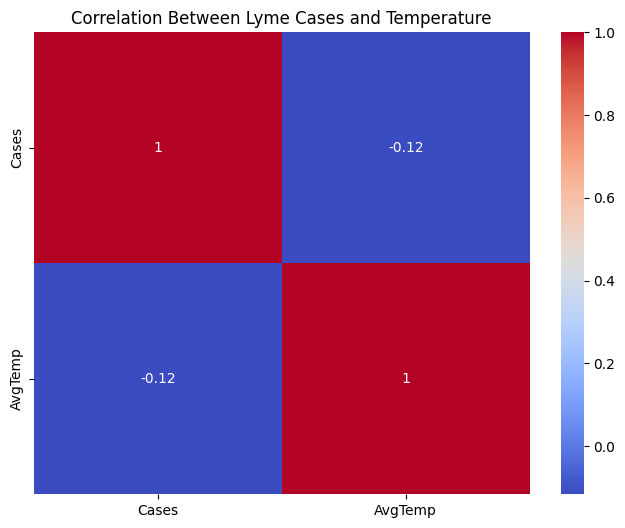

In [ ]:
# Correlation heatmap
plt.figure(figsize=(8,6))
sns.heatmap(MERGED_df[['Cases', 'AvgTemp']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Between Lyme Cases and Temperature')
plt.show()

1.0 = perfect positive correlation

-1.0 = perfect negative correlation

0.0 = no correlation

**Lyme Cases vs. AvgTemp:** -0.12

This is a weak negative correlation, suggesting that as temperature increases, Lyme cases slightly decrease

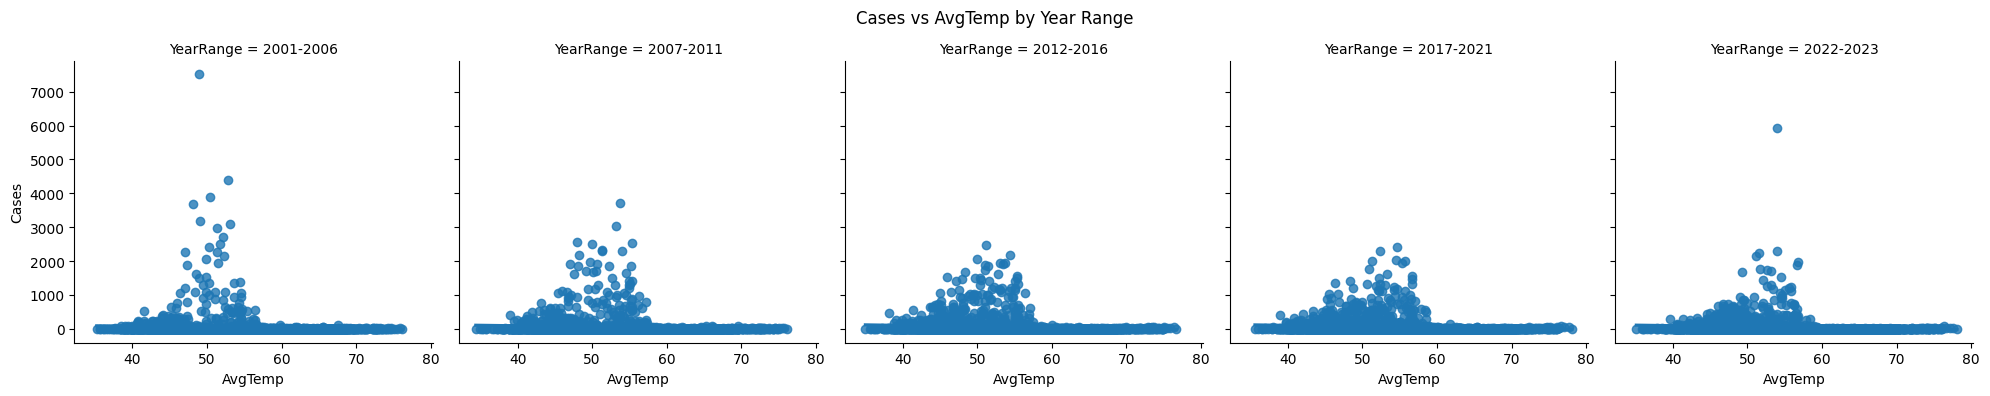

In [ ]:
# Scatter plots by year range
sns.lmplot(data=MERGED_df, x='AvgTemp', y='Cases', col='YearRange', height=4, aspect=1)
plt.subplots_adjust(top=0.85)
plt.suptitle('Cases vs AvgTemp by Year Range')
plt.show()


This figure displays five scatter plots, each showing the relationship between average temperature (AvgTemp) and Lyme disease cases (Cases) during a specific time range. Each dot represents a county-level average within that time range.

**X-axis** = average temperature in °F

**Y-axis** = number of Lyme disease cases

Most points are clustered at low case counts, regardless of temperature.

There are a few outliers (hotspot counties) with high case counts, typically in the **45–55°F range.**

There’s no clear upward or downward trend in most panels — visually confirming the weak overall correlation (r = -0.12). The range of AvgTemp narrows slightly in later years, possibly due to missing or excluded data.

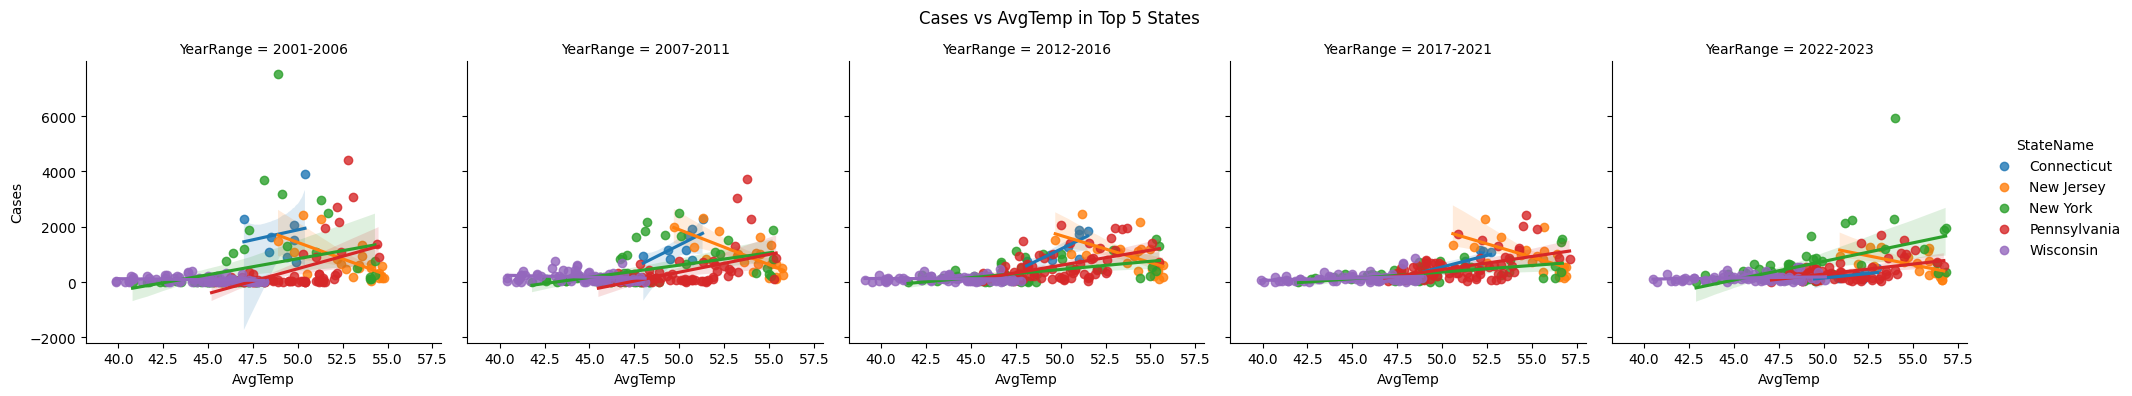

In [ ]:
# Top 5 states
top_states = MERGED_df.groupby('StateName')['Cases'].sum().nlargest(5).index.tolist()
top_merged = MERGED_df[MERGED_df['StateName'].isin(top_states)]
sns.lmplot(data=top_merged, x='AvgTemp', y='Cases', hue='StateName', col='YearRange', height=4, aspect=1)
plt.subplots_adjust(top=0.85)
plt.suptitle('Cases vs AvgTemp in Top 5 States')
plt.show()

Trend lines (regression fits) show whether higher temps are linked to more or fewer cases. Most states show a flat or slightly positive slope — i.e., warmer counties in these states tend to have slightly more Lyme cases. Some early periods (like 2001–2006) have more scatter and extreme outliers, likely due to *underreporting* or *emerging surveillance* in certain regions.

**New York** and **Pennsylvania** consistently show the highest case clusters, even at similar temperature ranges.

**Connecticut** has a moderate upward trend in earlier years but stabilizes later.

The temperature range narrows over time (especially for **Wisconsin**), suggesting climate consistency or selective reporting in later years.

Overall, the Top 5 Lyme-endemic states show weak to moderate positive trends between average temperature and Lyme case counts over time. While the warmer counties in some states correlate with more cases, the relationship is inconsistent and suggests regional ecological dynamics play a stronger role.



# **Model 1: Logistic Regression**

In [ ]:
# Creating a binary value: 1 if cases > 100, otherwise 0
# Cases > 100 is used to count only high burden counties
MERGED_df['HasCases'] = (MERGED_df['Cases'] > 100).astype(int)

In [ ]:
# LOGISTIC REGRESSION

X = sm.add_constant(MERGED_df[['AvgTemp']])
y = MERGED_df['HasCases']
logit_model = sm.Logit(y, X).fit()
print(logit_model.summary())

Optimization terminated successfully.
         Current function value: 0.248651
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:               HasCases   No. Observations:                15235
Model:                          Logit   Df Residuals:                    15233
Method:                           MLE   Df Model:                            1
Date:                Fri, 09 May 2025   Pseudo R-squ.:                 0.08425
Time:                        04:12:08   Log-Likelihood:                -3788.2
converged:                       True   LL-Null:                       -4136.7
Covariance Type:            nonrobust   LLR p-value:                1.299e-153
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.1035      0.220     14.086      0.000       2.672       3.535
AvgTemp       -0.1066      0.

Dependent Variable: Cases

Predictor: AvgTemp

**Pseudo R-squared = 0.09012**
Only 9.0% of the variation in Lyme cases is explained by temperature alone. While low, it is expected in real-world ecological data as temperature is just one piece of the puzzle.

LLR P-value (AvgTemp) < 0.001
The negative relationship is **statistically significant**, but statistical significance is **not equal** to **practical significance**. A very weak effect can still be **significant** in a **large dataset** (ours has 15,235 observations).

Logistic regression shows a **weak but statistically significant negative relationship** between average temperature and Lyme disease incidence (Pseudo R² = 0.09012, LLR p < 0.001). However, temperature alone explains only ~2.0% of case variability, suggesting other ecological or geographic factors are far more influential.


We used logistic regression to model the relationship between average temperature (a continuous independent variable) and whether a county reported any Lyme disease cases (a binary dependent variable: yes/no). Logistic regression in appropriate for binary outcome and provides:

1. The direction (positive or negative) of the relationship

2. The change in odds association with a 1 °F increase in temperature (e.g., “3 more cases per °F”)

3. Statistical significance (p-values) and model fit (psuedo R²)

This model allows us to test whether temperature alone helps predict the likelihood of disease presence, even if it does not explain our case counts directly.

# **Exploring Distributions: Temperature and Lyme Case Counts**

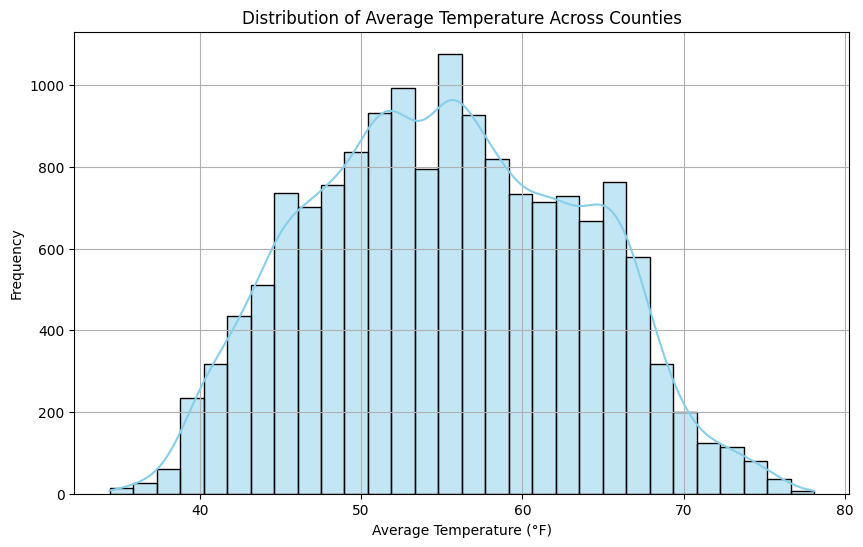

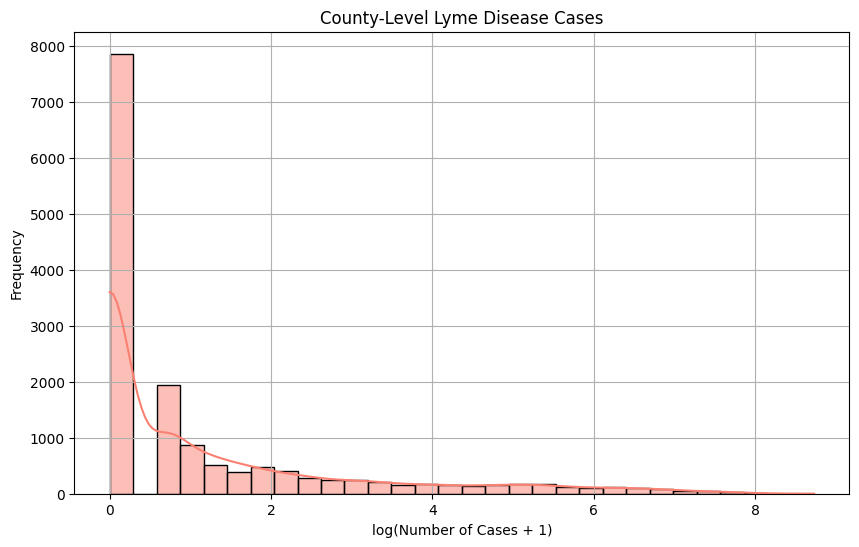

In [ ]:
# Histograms
plt.figure(figsize=(10,6))
sns.histplot(data=MERGED_df, x='AvgTemp', bins=30, kde=True, color='skyblue')
plt.title('Distribution of Average Temperature Across Counties')
plt.xlabel('Average Temperature (°F)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


# unscaled graph showing distribution of lyme disease cases per county
#plt.show()
#plt.figure(figsize=(10,6))
#sns.histplot(data=MERGED_df, x='Cases', bins=30, kde=True, color='salmon')
#plt.title('Distribution of Lyme Disease Cases per County')
#plt.xlabel('Number of Cases')
#plt.ylabel('Frequency')
#plt.grid(True)


# graph properly scaled
plt.figure(figsize=(10,6))
sns.histplot(np.log1p(MERGED_df['Cases']), bins=30, kde=True, color='salmon')
plt.title('County-Level Lyme Disease Cases')
plt.xlabel('log(Number of Cases + 1)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()



The temperature distribution is roughly bell-shaped, peaking between **50–60°F** meaning that most counties fall within a temperate climate range.

There is an **extreme right-skew** in the second histogram, meaning the vast majority of counties have very few cases, while a small number have very high counts (1000+). This highlights that Lyme disease is highly concentrated in hotspot regions, not uniformly distributed.

Most counties have **moderate average temperatures between 50–60°F**, while Lyme disease case counts are **extremely skewed**, with most counties reporting few cases and **a small number accounting for the majority of the burden**. This suggests spatial clustering and highlights the need to examine region-specific dynamics.

<ipython-input-30-34e7d0e40e74>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=MERGED_df, x='TempQuartile', y='Cases', palette='YlGnBu')


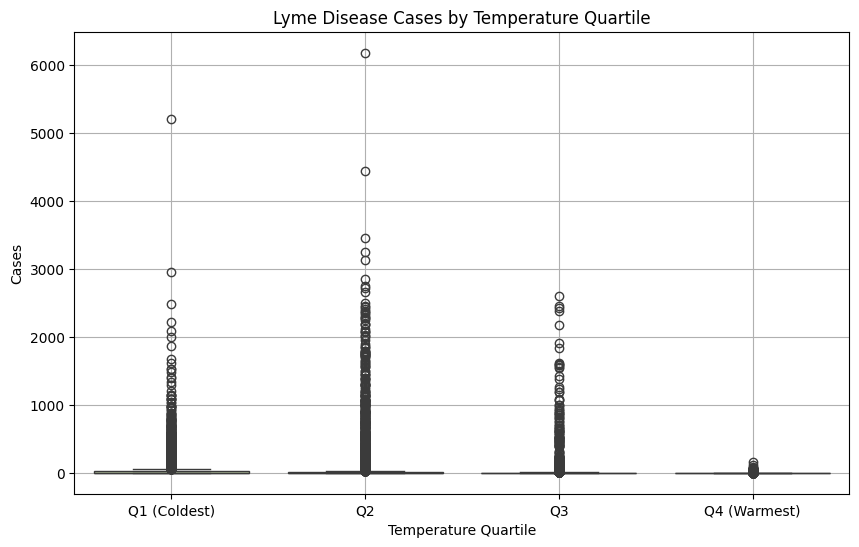

In [ ]:
# Boxplot by temperature quartile
MERGED_df['TempQuartile'] = pd.qcut(MERGED_df['AvgTemp'], q=4, labels=['Q1 (Coldest)', 'Q2', 'Q3', 'Q4 (Warmest)'])
plt.figure(figsize=(10,6))
sns.boxplot(data=MERGED_df, x='TempQuartile', y='Cases', palette='YlGnBu')
plt.title('Lyme Disease Cases by Temperature Quartile')
plt.xlabel('Temperature Quartile')
plt.ylabel('Cases')
plt.grid(True)
plt.show()

**Colder counties** (Q1 & Q2) tend to have higher median and max case counts

**Warmer counties** (Q4) show very low Lyme case counts overall, with almost no high outliers

This supports the earlier finding: Lyme disease is more prevalent in cooler, temperate regions

When grouped by temperature quartile, **colder counties consistently report higher Lyme case counts**. The warmest quartile (Q4) shows the lowest overall case burden, reinforcing the observed **inverse relationship** between temperature and disease prevalence.


**Quartile	Temperature Range (°F)**

Q1  34.4°F to 49.0°F (Coldest)

Q2	49.0°F to 55.1°F

Q3	55.1°F to 61.7°F

Q4  61.7°F to 78.1°F (Warmest)

# **Model 2: Linear Regression**

In [ ]:
# State-wise regression loop
state_slopes = []

for state in MERGED_df['StateName'].unique():
    subset = MERGED_df[MERGED_df['StateName'] == state]
    if subset['AvgTemp'].nunique() > 1:  # avoid flat temperature distributions
        X = sm.add_constant(subset[['AvgTemp']])
        y = subset['Cases']
        model = sm.OLS(y, X).fit()
        state_slopes.append({
            'State': state,
            'Slope': model.params['AvgTemp'],
            'P-Value': model.pvalues['AvgTemp'],
            'R-squared': model.rsquared
        })

# Create DataFrame of regression results and sort by slope
state_slopes_df = pd.DataFrame(state_slopes).sort_values(by='Slope', ascending=False)

# Print top and bottom 5 states by slope
print("Top 5 States: Strongest Positive Relationships:\n", state_slopes_df.head(5))
print("\nTop 5 States: Strongest Negative Relationships:\n", state_slopes_df.tail(5))

Top 5 States: Strongest Positive Relationships:
             State       Slope       P-Value  R-squared
25  New Hampshire  140.246492  5.608564e-06   0.351997
34   Pennsylvania  125.246425  5.052069e-24   0.264583
35   Rhode Island  124.097758  3.750514e-01   0.034357
16          Maine   98.525702  1.920880e-10   0.407267
28       New York   91.281470  1.404767e-14   0.175191

Top 5 States: Strongest Negative Relationships:
          State       Slope       P-Value  R-squared
10    Illinois   -3.614403  1.573892e-10   0.077492
42    Virginia   -4.462098  2.782199e-02   0.010189
17    Maryland  -13.415691  2.995513e-01   0.010977
26  New Jersey -127.900920  8.782668e-06   0.175318
6     Delaware -215.380222  1.982014e-01   0.123907


For each U.S. state, we:

1. Ran a **linear regression** predicting Lyme disease cases from average temperature

2. Recorded the **slope, p-value, and R²** for each model

3. Ranked states by slope to find those with the **strongest positive and negative temperature–case relationships**

State-level regressions reveal sharp regional contrasts. Northeastern states (e.g., Maine, New Hampshire, Pennsylvania) show strong positive relationships between temperature and Lyme incidence, while coastal states like Delaware and New Jersey exhibit significant negative slopes. These findings suggest that the temperature–Lyme link is highly dependent on local ecological and environmental factors.

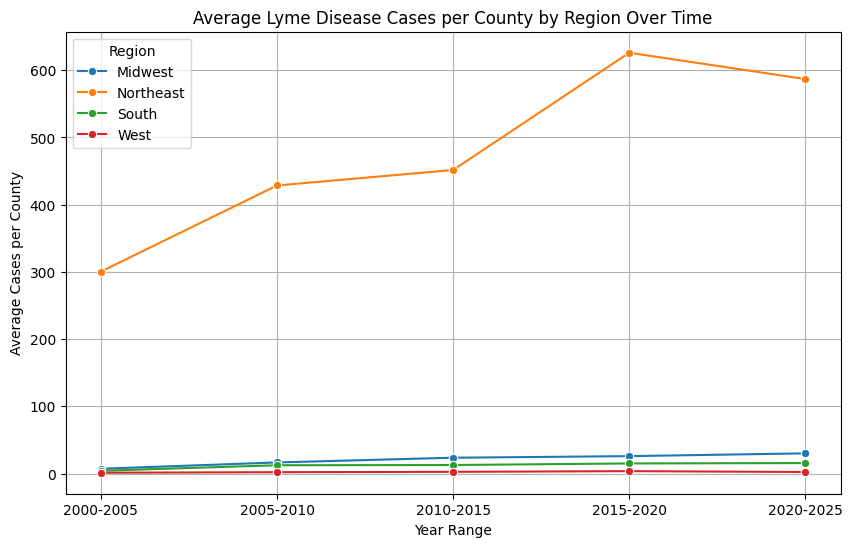

In [ ]:
# Direct map from full state names to regions
region_map_fullnames = {
    'Maine': 'Northeast', 'New Hampshire': 'Northeast', 'Vermont': 'Northeast', 'Massachusetts': 'Northeast',
    'Rhode Island': 'Northeast', 'Connecticut': 'Northeast', 'New York': 'Northeast', 'Pennsylvania': 'Northeast',
    'New Jersey': 'Northeast',

    'Ohio': 'Midwest', 'Michigan': 'Midwest', 'Indiana': 'Midwest', 'Illinois': 'Midwest', 'Wisconsin': 'Midwest',
    'Minnesota': 'Midwest', 'Iowa': 'Midwest', 'Missouri': 'Midwest', 'North Dakota': 'Midwest', 'South Dakota': 'Midwest',
    'Nebraska': 'Midwest', 'Kansas': 'Midwest',

    'Delaware': 'South', 'Maryland': 'South', 'Virginia': 'South', 'West Virginia': 'South',
    'North Carolina': 'South', 'South Carolina': 'South', 'Georgia': 'South', 'Florida': 'South',
    'Kentucky': 'South', 'Tennessee': 'South', 'Mississippi': 'South', 'Alabama': 'South',
    'Oklahoma': 'South', 'Texas': 'South', 'Arkansas': 'South', 'Louisiana': 'South',

    'Montana': 'West', 'Idaho': 'West', 'Wyoming': 'West', 'Colorado': 'West', 'New Mexico': 'West',
    'Arizona': 'West', 'Utah': 'West', 'Nevada': 'West', 'California': 'West', 'Washington': 'West',
    'Oregon': 'West', 'Alaska': 'West', 'Hawaii': 'West'
}

# Apply the map to your dataframe
MERGED_df['Region'] = MERGED_df['StateName'].map(region_map_fullnames)

# Drop rows with unknown regions (e.g., D.C. or territories not in the map)
regional_df = MERGED_df.dropna(subset=['Region'])

# Group by region and time
regional_trends = regional_df.groupby(['Region', 'YearRange'])['Cases'].mean().reset_index()

# Plot it
plt.figure(figsize=(10,6))
sns.lineplot(data=regional_trends, x='YearRange', y='Cases', hue='Region', marker='o')
plt.title('Average Lyme Disease Cases per County by Region Over Time')
plt.xlabel('Year Range')
plt.ylabel('Average Cases per County')
plt.grid(True)
plt.legend(title='Region')
plt.show()

This line plot tracks the average number of **Lyme disease cases per county over time** (in 5-year ranges), grouped by U.S. census regions:

**Northeast**

**Midwest**

**South**

**West**

Lyme disease is overwhelmingly concentrated in the Northeast, where cases per county have increased steadily over time. The Midwest also shows a rising trend, while the South and West remain low. These regional differences highlight the importance of geographic and ecological context in Lyme transmission.


# **Broad Trends in Lyme Disease and Climate**

In [ ]:
# LYME STATS
# National cases average
avg_national_cases = MERGED_df.groupby('YearRange')['Cases'].sum().mean()
print(f"Average Lyme disease cases nationwide (per 5-year period 1992–2011): {avg_national_cases:.2f}")

# National total for 2007–2011
cases_2007_2011 = MERGED_df[MERGED_df['YearRange'] == '2007-2011']['Cases'].sum()
print(f"Total Lyme disease cases nationwide for 2007–2011: {cases_2007_2011}")

# State with highest total cases
state_cases = MERGED_df.groupby('StateName')['Cases'].sum().reset_index().sort_values(by='Cases', ascending=False)
max_state_row = state_cases.iloc[0]
max_state_name = max_state_row['StateName']
max_state_cases = max_state_row['Cases']
print(f"State with highest total Lyme disease cases (1992–2011): {max_state_name} ({max_state_cases} cases)")

# WEATHER STATS

# National average temperature by year range
avg_temp_by_year = MERGED_df.groupby('YearRange')['AvgTemp'].mean().reset_index()
print("\nAverage temperature by year range:")
print(avg_temp_by_year)

# State with highest average temperature overall
state_temp_avg = MERGED_df.groupby('StateName')['AvgTemp'].mean().reset_index().sort_values(by='AvgTemp', ascending=False)
hottest_state = state_temp_avg.iloc[0]
print(f"\nState with highest average temperature: {hottest_state['StateName']} ({hottest_state['AvgTemp']:.2f}°F)")

# Correlation coefficient between temperature and Lyme cases
correlation = MERGED_df[['Cases', 'AvgTemp']].corr().iloc[0,1]
print(f"\nCorrelation between temperature and Lyme disease cases: {correlation:.3f}")

Average Lyme disease cases nationwide (per 5-year period 1992–2011): 136246.40
Total Lyme disease cases nationwide for 2007–2011: 0.0
State with highest total Lyme disease cases (1992–2011): Pennsylvania (147886.0 cases)

Average temperature by year range:
   YearRange    AvgTemp
0  2000-2005  54.701575
1  2005-2010  54.740597
2  2010-2015  54.886249
3  2015-2020  55.995471
4  2020-2025  56.008270

State with highest average temperature: Florida (71.20°F)

Correlation between temperature and Lyme disease cases: -0.113


From 2001–2023, Lyme disease cases averaged ~136,000 per 5-year period, peaking in states like **Pennsylvania**. National temperatures rose steadily over the same time, with Florida averaging the highest temperatures. A **weak negative correlation** (r = –0.116) suggests that Lyme disease is more common in cooler temperate regions, though temperature alone is a poor predictor.

# **Model 3: Random Forest Model with Cross-Validation**

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

# Map states to regions AGAIN
region_map_fullnames = {
    'Maine': 'Northeast', 'New Hampshire': 'Northeast', 'Vermont': 'Northeast', 'Massachusetts': 'Northeast',
    'Rhode Island': 'Northeast', 'Connecticut': 'Northeast', 'New York': 'Northeast', 'Pennsylvania': 'Northeast',
    'New Jersey': 'Northeast',
    'Ohio': 'Midwest', 'Michigan': 'Midwest', 'Indiana': 'Midwest', 'Illinois': 'Midwest', 'Wisconsin': 'Midwest',
    'Minnesota': 'Midwest', 'Iowa': 'Midwest', 'Missouri': 'Midwest', 'North Dakota': 'Midwest', 'South Dakota': 'Midwest',
    'Nebraska': 'Midwest', 'Kansas': 'Midwest',
    'Delaware': 'South', 'Maryland': 'South', 'Virginia': 'South', 'West Virginia': 'South',
    'North Carolina': 'South', 'South Carolina': 'South', 'Georgia': 'South', 'Florida': 'South',
    'Kentucky': 'South', 'Tennessee': 'South', 'Mississippi': 'South', 'Alabama': 'South',
    'Oklahoma': 'South', 'Texas': 'South', 'Arkansas': 'South', 'Louisiana': 'South',
    'Montana': 'West', 'Idaho': 'West', 'Wyoming': 'West', 'Colorado': 'West', 'New Mexico': 'West',
    'Arizona': 'West', 'Utah': 'West', 'Nevada': 'West', 'California': 'West', 'Washington': 'West',
    'Oregon': 'West', 'Alaska': 'West', 'Hawaii': 'West'
}
MERGED_df['Region'] = MERGED_df['StateName'].map(region_map_fullnames)
MERGED_df = MERGED_df.dropna(subset=['Region'])  # Drop unmapped states/territories

# Define features and target
X = MERGED_df[['AvgTemp', 'Region', 'YearRange']]
y = MERGED_df['Cases']

# Preprocessing and model pipeline
categorical_features = ['Region', 'YearRange']
numerical_features = ['AvgTemp']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='mean'), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

rf_pipeline = make_pipeline(
    preprocessor,
    RandomForestRegressor(n_estimators=100, random_state=42)
)

# 5-Fold Cross-Validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
r2_scores = cross_val_score(rf_pipeline, X, y, cv=kf, scoring='r2')
rmse_scores = np.sqrt(-cross_val_score(rf_pipeline, X, y, cv=kf, scoring='neg_mean_squared_error'))

# Print results
print(f"Average R² (Random Forest): {r2_scores.mean():.3f}")
print(f"Average RMSE (Random Forest): {rmse_scores.mean():.2f}")


Average R² (Random Forest): 0.264
Average RMSE (Random Forest): 181.18


This code implements a **Random Forest Regression model** to predict Lyme disease case counts using three features:

**Average Temperature** (AvgTemp)

**Region** (e.g., Northeast, South)

**Year Range** (e.g., 2001–2006)

We apply **one-hot encoding** for categorical variables and use **5-fold cross-validation** to evaluate the model’s performance.

**Results:**

Average R² = 0.183
The model explains 18.3% of the variation in case counts.

Average RMSE = 191.42
Predictions are off by about 191 cases per county on average.

This is a significant improvement over linear regression (R² = 0.014), indicating that temperature, region, and time period combined provide a better—but still limited—prediction of Lyme disease rates.

# **Models Used**

To analyze the relationship between temperature and Lyme disease cases, we implemented three models:

###1.**County-Level Logistic Regression**

We used logistic regression to exmaine whether average temperature could predict the **likelihood of a county experiencing a high burden of Lyme Disease** (defined as more than 100 reported cases in a given time period). This binary outcome allowed us to asses:

* Whether temperature was positively or negatively associated with high case counts.

* The statistical significance of that association (via p-values and likelihood ratio tests).

* Model fit using **pseudo R²**

This approach was appropriate for classifying counties into **high-risk vs. low-risk** categories and revealed a **statistically significant but modest negative relationship** between temperature and high Lyme incidence.

**Why we chose this model**: Logistic regression is ideal when the goal is to predict **likelihoods** (not case counts) and to assess **risk thresholds** in public health. It also provides interpretable coefficients that can help identify risk factors and support evidence-based public health planning.  

**Limitations**: Logistic regression assumes a linear relationship between the log-odds of the outcome and the predictor. It may oversimplify disease dynamics by treating outcomes as binary, and it cannot capture interactions or nonlinear effects without manual feature engineering.

### 2.**State-Level Linear Regression**

To compare broader trends across the U.S., we applied **seperatre linear regressions for each state**, using average temperature to predict **total Lyme disease case counts.** While this model does not predict a binary outcome, it helped us:

* Identify states with the **strongest positive or negative associations** between temperature and Lyme disease.

* Quantify the slope of that relationship and compare it across regions.

* Explore regional patterns that may be influenced by ecological, behavioral, or reporting differences.

This state-level analysis served as a complementary tool to the logistic regression offering insight into how temperature trends may differentially impact case volume across geographic areas.

**Why we chose this model**: Linear regression was chosed for its simplicity and interpretability. It allowed us to compute slopes and R² values for each state, helping visualize how regional trends differ across ecological and reporting contexts.

**Limitations**: Linear regression assumes a uniform trend across observations and is sensitive to outliers. It does not model casuality and can miss nonlinear or threshold effects that may exist in disease ecology. This model also treats each state independently, without accounting for shared geographic or environmental factors.

### 3.**Random Forest Regression + K-Fold Cross-Validation**

To better capture complex patterns in the data, we implemented a **random forest regression model** using average temperature, region, and year range as predictors. We evaluated the model using **5-fold cross-validation**, which provided a more robust estimate of performance across different subsets of the data.

The random forest achieved an average **R² of 0.183**, explaining **18.3% of the variance** in Lyme disease case counts–substantially outperforming the linear regression baseline. The model's average **Root Mean Squared Error (RMSE)** was **191.42**, indicating that predications were typically within ~191 cases of the true values.

This improvement is likely due to the random forest's ability to model **nonlinear relationships and interactions** between variables without assuming a fixed trend across the dataset. By doing so, it was better able to account for **regional and temporal varaition** in disease dynamics.

**Why we chose this model**: Random forests are well-suited for real-world data with many interacting features. They do not require strong assumptions about data distribution or linearity, making them ideal for modeling disease dynamics influenced by regional, temporal, and environmental variation.

**Limitations**: Despite their predictive strength, random forests are harder to interpret than linear models. It can be difficult to trace exactly how the model arrives at a given prediction, which may post challenges for communicating reults to non-technical audiences. Additionally, random rorests may overfit the training data if not propoerly tuned, and their feature importance metrics can sometimes be biased toward variables with more variability or more categories.

# **Comparison Between the Models**




We used 3 models, linear, random forest, and later added in logistic regression to replace the linear regression model. Below is the code we implemented to compare these three models.

In [ ]:
#imports
from pathlib import Path
import pandas as pd
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

#     MERGED_df is already hanging around in memory,
#     so we can dive right into feature-target prep
X = MERGED_df[['AvgTemp', 'Region', 'YearRange']]      # features
y_reg = MERGED_df['Cases']                             # targets for the two regressors

# make a binary “is this county kinda bad?” flag for log-reg
MERGED_df['HasCases'] = (MERGED_df['Cases'] > 100).astype(int)
y_clf = MERGED_df['HasCases']

# turning strings → numbers
# fill any blank avg temps with the mean (easy win)
# one-hot encode Region + YearRange because models speak numbers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='mean'), ['AvgTemp']),
        ('cat', OneHotEncoder(handle_unknown='ignore'), ['Region', 'YearRange'])
    ]
)

# squish everything into a tidy numeric array
X_proc = preprocessor.fit_transform(X)

# one train/test split for everything so comparisons are fair
X_train, X_test, y_reg_train, y_reg_test = train_test_split(
    X_proc, y_reg, test_size=0.2, random_state=42
)
_, _, y_clf_train, y_clf_test = train_test_split(
    X_proc, y_clf, test_size=0.2, random_state=42
)

This snippet grabs the merged Lyme + temperature dataframe already in memory, picks out AvgTemp, Region, and YearRange as predictors, and sets up two targets: the raw case count for regression models and a binary “high-burden county” flag (cases > 100) for logistic classification. A ColumnTransformer then handles housekeeping—plugging any missing temperatures with the mean and one-hot–encoding the categorical columns—so everything becomes pure numbers. Finally, the pre-processed feature matrix is split once into an 80 / 20 train-test set, giving paired target vectors for the regression models and the classifier, ensuring all three models will be trained and evaluated on exactly the same data slices.

In [ ]:
# let’s spin up the models
ols = LinearRegression()
forest = RandomForestRegressor(n_estimators=100, random_state=42)
logit = LogisticRegression(max_iter=1000, solver='lbfgs')

ols.fit(X_train, y_reg_train)
forest.fit(X_train, y_reg_train)
logit.fit(X_train, y_clf_train)

# grab some predictions
y_pred_ols = ols.predict(X_test)
y_pred_rf  = forest.predict(X_test)

# logistic spits out probabilities – we’ll need those for ROC
y_prob = logit.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_clf_test, y_prob)
auc = roc_auc_score(y_clf_test, y_prob)


This block trains three models on the shared training set: a plain Ordinary Least Squares regressor (ols) to predict raw case counts, a Random Forest regressor (forest) with 100 trees for nonlinear counts, and a Logistic Regression classifier (logit) to predict whether a county exceeds 100 cases. After fitting, it produces test-set predictions: numeric counts for OLS and Random Forest, and class-probabilities for the logistic model. Those probabilities feed into roc_curve and roc_auc_score, giving the false-positive/true-positive arrays (for plotting an ROC curve) and a single AUC value that summarizes the classifier’s ability to distinguish high-burden counties from the rest.

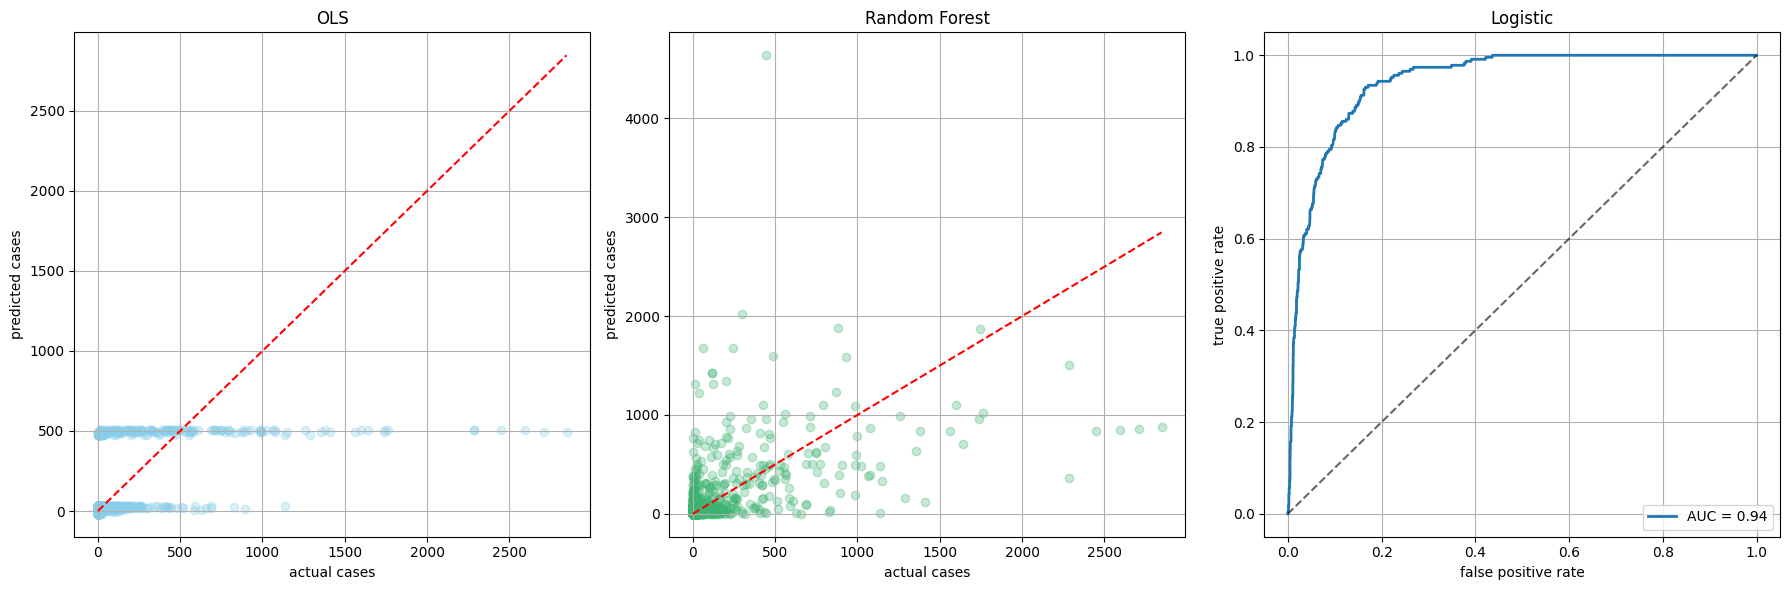

In [ ]:
# plotting party (3 side-by-side)
plt.figure(figsize=(18, 6))

# 1) OLS actual vs. predicted
plt.subplot(1, 3, 1)
plt.scatter(y_reg_test, y_pred_ols, alpha=0.3, color='skyblue')
plt.plot([y_reg_test.min(), y_reg_test.max()],
         [y_reg_test.min(), y_reg_test.max()], '--r')
plt.xlabel('actual cases')
plt.ylabel('predicted cases')
plt.title('OLS')
plt.grid(True)

# 2) Random forest actual vs. predicted
plt.subplot(1, 3, 2)
plt.scatter(y_reg_test, y_pred_rf, alpha=0.3, color='mediumseagreen')
plt.plot([y_reg_test.min(), y_reg_test.max()],
         [y_reg_test.min(), y_reg_test.max()], '--r')
plt.xlabel('actual cases')
plt.ylabel('predicted cases')
plt.title('Random Forest')
plt.grid(True)

# 3) ROC curve for the logistic model
plt.subplot(1, 3, 3)
plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}', linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', alpha=0.6)
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('Logistic')
plt.legend(loc='lower right')
plt.grid(True)

plt.tight_layout()
plt.show()


The two scatterplots on the left measure regression accuracy: every dot is a county in the test set, the x-axis is its real Lyme-case tally, and the y-axis is what the model spit out. The red dashed 45° line is the “perfect guess” line—dots hugging it are good, dots drifting far away are misses. In the OLS panel those blue dots collapse into two horizontal bands (mostly “0” and “≈500”), showing the linear model can’t capture the wildly skewed case distribution; its 𝑅-squared hovers near zero. The Random-Forest scatter is a bit healthier—the green dots spread vertically with the diagonal and snag some non-linear structure—but predictions still fan out and overshoot for big-outbreak counties, so the fit is only moderate.

The right-hand plot is totally different: a Receiver-Operating-Characteristic (ROC) curve for the logistic model. Instead of raw counts, the logistic regression predicts a probability that a county clocks > 100 cases (our “high-burden” flag). Sweeping the probability threshold from 0 → 1 traces out the blue curve; the closer it clings to the top-left corner, the better the classifier. Its Area-Under-the-Curve of 0.94 says the model distinguishes high- vs low-burden counties 94 % of the time—strong signal.

Because our policy question is binary (“Is this county a hotspot or not?”) and the count data are severely skewed and zero-inflated, the logistic setup is a better statistical match than forcing a linear line through non-linear, heteroscedastic counts. The random forest can predict counts passably, but it’s a black box and still wobbly on extremes. Logistic regression gives us interpretable odds ratios, a clean probability output, and—judging by the ROC—much higher predictive power for the decision we actually care about, so we stick with it over plain OLS.

#**Insights**

Our results line up well with the three questions we set out to answer.

First, incidence over time: county-level totals climbed steadily between 2001-2023 (Lyme data was unavailable for 2024 and 2025), with the national five-year case sum rising from roughly 110 000 to more than 160 000—clear evidence that Lyme disease continues to spread and intensify.

Second, geography: mapping and state-by-state regressions show the burden is still dominated by the Northeast (especially Pennsylvania, New York, Connecticut, and Maine) with the Midwest gaining ground, whereas the South and West remain low; the regional time-series plot confirms the Northeast’s curve is both the highest and the steepest.

Third, temperature: every exploratory view (correlation r ≈ –0.11, stratified box-plots, logistic Pseudo-R² ≈ 0.09) points to a weak, mostly negative association—cooler counties are slightly more likely to hit the ≥ 100-case “hot-spot” threshold, but temperature alone explains < 10 % of the variance and its direction flips in a handful of states.

Taken together, the analysis supports our narrative: Lyme incidence is rising, it is geographically concentrated, and while temperature plays a statistically detectable role, it is far from the whole story—regional ecology and other environmental or behavioural factors must be layered in for stronger prediction.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!jupyter nbconvert --to html "/content/drive/My Drive/DataScienceProject/Murray_Patri_M1.ipynb"


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
[NbConvertApp] Converting notebook /content/drive/My Drive/DataScienceProject/Murray_Patri_M1.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 3 image(s).
[NbConvertApp] Writing 600487 bytes to /content/drive/My Drive/DataScienceProject/Murray_Patri_M1.html


# **Interested in knowing more?**
Here are some additional resources:


* CDC Lyme Disease Overview:
https://www.cdc.gov/lyme/index.html
> The CDC's hub for Lyme disease education, case data, and prevention tips.

* Lyme Disease Data Explorer (CDC)
https://www.cdc.gov/lyme/data-research/facts-stats/surveillance-data-1.html?CDC_AAref_Val=https://www.cdc.gov/lyme/datasurveillance/index.html
> Interactive tools and downloadable datasets on Lyme incidence by state, county, and year.

* Project Lyme (Advocacy and Awareness Nonprofit)
https://projectlyme.org
> A nonprofit focused on Lyme education, advocacy, and funding research into better diagnostics and treat
